## Objective: Text Classification with Logistic Regression  

### Overview  
This task involves classifying movie reviews from the **Stanford Sentiment Treebank (SST)** into five sentiment categories based on their sentiment scores.  

### Part 2.1: Preprocessing for Classification  
- Convert sentiment scores **(0 to 1)** into **five discrete classes**:  
  - **0 - 0.2** → Class 0: "Very Negative"  
  - **0.2 - 0.4** → Class 1: "Negative"  
  - **0.4 - 0.6** → Class 2: "Neutral"  
  - **0.6 - 0.8** → Class 3: "Positive"  
  - **0.8 - 1.0** → Class 4: "Very Positive"  

## Libraries Used  

| Library          | Purpose |
|-----------------|--------------------------------------------------------------------------|
| `datasets` (Hugging Face) | Loads the Stanford Sentiment Treebank (SST) dataset. |
| `numpy`         | Performs numerical operations and matrix manipulations. |
| `pandas`        | Handles structured data using DataFrames. |
| `tqdm`          | Displays progress bars for loops and iterations. |
| `prettytable`   | Formats and displays tabular data in a readable format. |
| `seaborn`       | Enhances data visualization with statistical plotting tools. |
| `matplotlib.pyplot` | Generates plots and visualizations for data analysis. |
| `re`            | Provides regular expressions for text preprocessing and cleaning. |
| `contractions`  | Expands contractions in text (e.g., "can't" → "cannot") for better NLP preprocessing. |



In [23]:
from datasets import load_dataset
import numpy as np
import pandas as pd
from tqdm import tqdm
from prettytable import PrettyTable
import seaborn as sns
import matplotlib.pyplot as plt
import re
import contractions
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
dataset = load_dataset("sst",trust_remote_code=True)

In [3]:
dataset


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'tokens', 'tree'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['sentence', 'label', 'tokens', 'tree'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['sentence', 'label', 'tokens', 'tree'],
        num_rows: 2210
    })
})

## Overview of the Dataset  

The **Stanford Sentiment Treebank (SST)** dataset consists of movie reviews with sentiment annotations. It is structured as follows:  

| Split       | Number of Samples | Features Available |
|------------|------------------|-------------------|
| **Train**      | 8,544             | `sentence`, `label`, `tokens`, `tree` |
| **Validation** | 1,101             | `sentence`, `label`, `tokens`, `tree` |
| **Test**       | 2,210             | `sentence`, `label`, `tokens`, `tree` |

### Features Description:  
- **`sentence`**: The text of the movie review.  
- **`label`**: A sentiment score (ranging from **0 to 1**).  
- **`tokens`**: Tokenized words of the sentence.  
- **`tree`**: Syntactic tree structure (not required for this task).  


In [4]:
# Convert to a list of dictionaries for easier handling
data_samples = dataset['train'][:10]  # Fetch first 10 samples

# Create a PrettyTable instance
table = PrettyTable()
table.field_names = ["Index", "Sentence", "Sentiment Score"]

# Add rows to the table
for i, (sentence, score) in enumerate(zip(data_samples['sentence'], data_samples['label'])):
    table.add_row([i, sentence, round(score, 3)])

# Print the table
print(table)

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+
| Index |                                                                                                               Sentence                                                                                                              | Sentiment Score |
+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+
|   0   |                        The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .            

In [5]:
# Remove 'tokens' and 'tree' columns from all splits
dataset = dataset.remove_columns(['tokens', 'tree'])

# Display the updated dataset structure
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['sentence', 'label'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2210
    })
})


In [6]:
def clean_text(text):
    """Normalize text: fix spacing, expand contractions, remove possessives, and clean punctuation."""

    # Remove spaces around apostrophes first (e.g., "he 's" → "he's")
    text = re.sub(r"\s*'\s*", "'", text)

    # Expand contractions (e.g., "he's" → "he is", "can't" → "cannot")
    text = contractions.fix(text)

    # Remove possessive 's correctly (e.g., "century's" → "century", but keeps "it's" → "it is")
    text = re.sub(r"\b(\w+)'s\b", r"\1", text)  

    # Remove all types of quotes (`` '' "" “ ” ‘ ’) while keeping valid apostrophes
    text = re.sub(r"[\"`'“”‘’]+", "", text)

    # Insert spaces before capital letters in merged words (e.g., "coWriter" → "co Writer")
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)

    # Insert spaces before numbers in merged words (e.g., "song1999" → "song 1999")
    text = re.sub(r'([a-zA-Z])(\d)', r'\1 \2', text)

    # Remove special characters except valid ones (letters, numbers, spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove extra spaces caused by cleaning
    text = re.sub(r'\s+', ' ', text).strip()

    return text.lower()

def clean_dataset(dataset):
    """Apply text cleaning to all splits (train, validation, test)."""
    cleaned_splits = {}

    for split in dataset.keys():
        # Convert to DataFrame
        df = pd.DataFrame(dataset[split])

        # Remove duplicates and missing values
        df = df.drop_duplicates().dropna()

        # Clean sentence text
        df['sentence'] = df['sentence'].apply(clean_text)

        # Convert back to Hugging Face Dataset format
        cleaned_splits[split] = dataset[split].from_pandas(df)

    return cleaned_splits

def display_samples(dataset, split, title="Dataset Samples"):
    """Displays the first 5 samples of a dataset split using PrettyTable."""
    table = PrettyTable()
    table.field_names = ["Index", "Sentence", "Sentiment Score"]
    
    # Fetch first 5 samples
    for i, (sentence, score) in enumerate(zip(dataset[split]['sentence'][:5], dataset[split]['label'][:5])):
        table.add_row([i, sentence, round(score, 3)])

    print(f"\n{title}\n")
    print(table)

# Show Before Cleaning
display_samples(dataset, 'train', "Before Cleaning")

# Apply Cleaning
dataset = clean_dataset(dataset)

# Show After Cleaning
display_samples(dataset, 'train', "After Cleaning")



Before Cleaning

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+
| Index |                                                                                                               Sentence                                                                                                              | Sentiment Score |
+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+
|   0   |                        The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven S

In [7]:
# Convert cleaned dataset to Pandas DataFrames
training_set = pd.DataFrame(dataset['train'])
validation_set = pd.DataFrame(dataset['validation'])
test_set = pd.DataFrame(dataset['test'])

# Function to display samples using PrettyTable
def display_the_samples(df, title, num_samples=5):
    table = PrettyTable()
    table.field_names = ["Index", "Sentence", "Sentiment Score"]
    
    for i in range(min(num_samples, len(df))):
        table.add_row([i, df.iloc[i]["sentence"], df.iloc[i]["label"]])
    
    print(f"\n{title} (Size: {len(df)} samples):\n")
    print(table)

# Display first 5 samples from each set along with dataset size
display_the_samples(training_set, "Training Set")
display_the_samples(validation_set, "Validation Set")
display_the_samples(test_set, "Test Set")



Training Set (Size: 8534 samples):

+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+
| Index |                                                                                                    Sentence                                                                                                   |  Sentiment Score   |
+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+
|   0   |                     the rock is destined to be the 21st century new conanand that he is going to make a splash even greater than arnold schwarzenegger jeanclaud van damme or steven segal                    | 0.6944400072097778 |
|   1  

## Sentiment Label Mapping

This code maps the continuous sentiment scores (ranging from 0 to 1) into five discrete sentiment classes:

### **Label Mapping Function**
The function `map_label(label)` categorizes sentiment scores into five classes:
- **0 (Very Negative)**: Scores between **0** and **0.2**.
- **1 (Negative)**: Scores between **0.2** and **0.4**.
- **2 (Neutral)**: Scores between **0.4** and **0.6** .
- **3 (Positive)**: Scores between **0.6** and **0.8** .
- **4 (Very Positive)**: Scores between **0.8** and **1.0** .


In [8]:
def map_label(label):
    if label >=0  and label <= 0.2:
        return 0  # Very Negative
    elif label <= 0.4:
        return 1  # Negative
    elif label <= 0.6:
        return 2  # Neutral
    elif label <= 0.8:
        return 3  # Positive
    else:
        return 4  # Very Positive
    
training_set['label'] = training_set['label'].apply(map_label)
validation_set['label'] = validation_set['label'].apply(map_label)
test_set['label'] = test_set['label'].apply(map_label)

display_the_samples(training_set, "Training Set")
display_the_samples(validation_set, "Validation Set")
display_the_samples(test_set, "Test Set")



Training Set (Size: 8534 samples):

+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+
| Index |                                                                                                    Sentence                                                                                                   | Sentiment Score |
+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+
|   0   |                     the rock is destined to be the 21st century new conanand that he is going to make a splash even greater than arnold schwarzenegger jeanclaud van damme or steven segal                    |        3        |
|   1   | the gorge

In [9]:
# Convert datasets to NumPy arrays
train_sentences = np.array(training_set['sentence'])
train_labels = np.array(training_set['label'])

val_sentences = np.array(validation_set['sentence'])
val_labels = np.array(validation_set['label'])

test_sentences = np.array(test_set['sentence'])
test_labels = np.array(test_set['label'])

# Create a PrettyTable
table = PrettyTable()
table.field_names = ["Dataset", "Sentences Shape", "Labels Shape"]

# Add dataset details
table.add_row(["Training Set", train_sentences.shape, train_labels.shape])
table.add_row(["Validation Set", val_sentences.shape, val_labels.shape])
table.add_row(["Test Set", test_sentences.shape, test_labels.shape])

# Print the table
print(table)


+----------------+-----------------+--------------+
|    Dataset     | Sentences Shape | Labels Shape |
+----------------+-----------------+--------------+
|  Training Set  |     (8534,)     |   (8534,)    |
| Validation Set |     (1100,)     |   (1100,)    |
|    Test Set    |     (2210,)     |   (2210,)    |
+----------------+-----------------+--------------+


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18192\4174154056.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train['label'], palette='Blues', ax=axes[0])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18192\4174154056.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=val['label'], palette='Blues', ax=axes[1])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18192\4174154056.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=test['label'], palette='Blues', ax=axes[2])


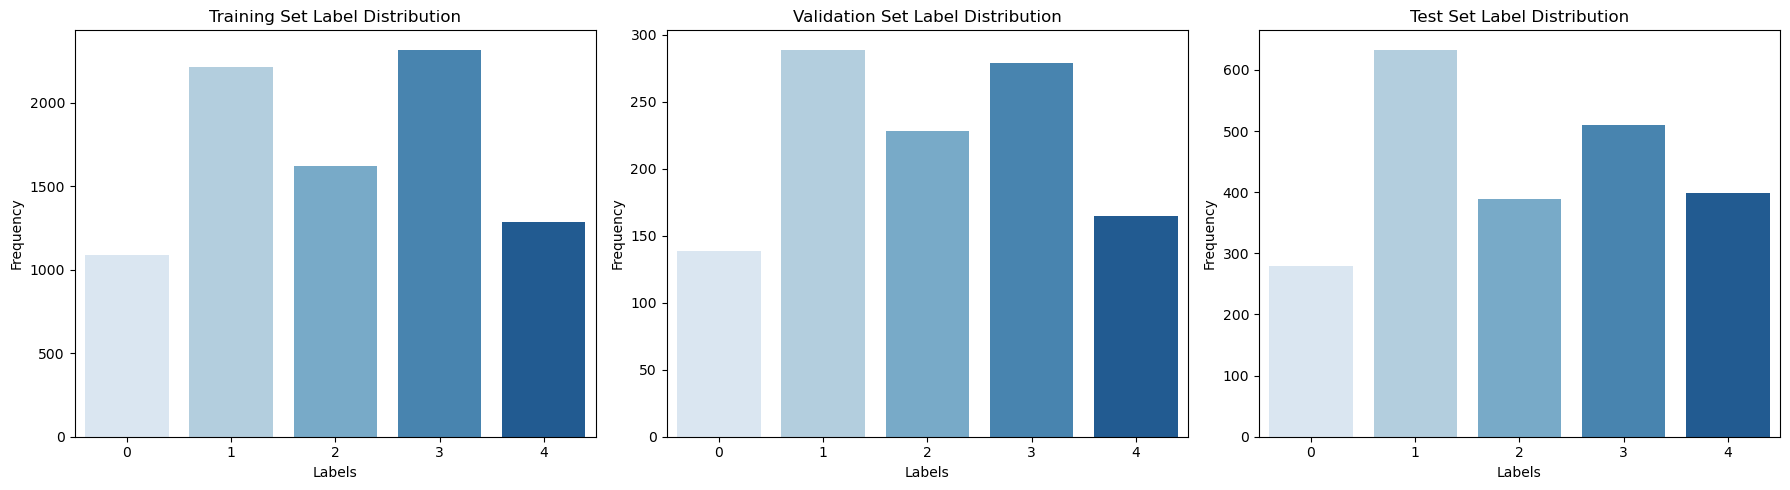

In [11]:
def plot_label_distributions(train, val, test):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

    sns.countplot(x=train['label'], palette='Blues', ax=axes[0])
    axes[0].set_title("Training Set Label Distribution")
    axes[0].set_xlabel("Labels")
    axes[0].set_ylabel("Frequency")

    sns.countplot(x=val['label'], palette='Blues', ax=axes[1])
    axes[1].set_title("Validation Set Label Distribution")
    axes[1].set_xlabel("Labels")
    axes[1].set_ylabel("Frequency")

    sns.countplot(x=test['label'], palette='Blues', ax=axes[2])
    axes[2].set_title("Test Set Label Distribution")
    axes[2].set_xlabel("Labels")
    axes[2].set_ylabel("Frequency")

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

# Call the function to plot
plot_label_distributions(training_set, validation_set, test_set)


### Observations:
- The dataset is relatively imbalanced, with some classes having significantly more samples than others.
- Class 1 (Negative) and Class 3 (Positive) are more frequent across all sets, while Class 0 (Very Negative) and Class 4 (Very Positive) have fewer samples.
- The distribution in the validation and test sets follows a similar pattern to the training set, ensuring consistency.

This imbalance may impact model performance, requiring techniques such as class weighting, oversampling, or data augmentation to improve results.

## Model Evaluation: Precision, Recall, and F1 Score Calculation  

This section outlines the implementation of performance evaluation metrics for a classification model, including **Precision**, **Recall**, **F1 Score**, and **Confusion Matrix** calculations.

### 1. **Confusion Matrix Calculation**  
A **confusion matrix** is created using the `confusion_matrix_scratch` function, which computes a **num_classes × num_classes** matrix, where:  
- Rows represent the **actual (true) labels**  
- Columns represent the **predicted labels**  
- Each cell **(i, j)** indicates the number of times a true class **i** was predicted as class **j**  

The confusion matrix helps visualize model performance by showing **correct and incorrect predictions** across all classes.

### 2. **Precision, Recall, and F1 Score Computation**  
The function `calculate_precision_recall_f1(cm)` computes precision, recall, and F1 score for each class using the confusion matrix.  

#### **Precision (Positive Predictive Value)**
Precision measures how many of the predicted positive instances were actually correct:  
$$ Precision = \frac{TP}{TP + FP} $$  
Where:  
- **TP** (True Positives): Correctly predicted instances of a class  
- **FP** (False Positives): Instances incorrectly classified as the class  

#### **Recall (Sensitivity or True Positive Rate)**
Recall measures how many actual positive instances were correctly predicted:  
$$ Recall = \frac{TP}{TP + FN} $$  
Where:  
- **FN** (False Negatives): Actual instances of a class that were incorrectly predicted as another class  

#### **F1 Score (Harmonic Mean of Precision & Recall)**
F1 Score balances Precision and Recall, providing a single performance metric:  
$$ F1 = \frac{2 \times Precision \times Recall}{Precision + Recall} $$  
It ensures that both false positives and false negatives are considered.

### 3. **Macro-Averaged Precision, Recall, and F1 Score**
To summarize model performance across all classes, the **macro-averaged** values are computed as:  
$$ MacroPrecision = \frac{1}{N} \sum_{i=1}^{N} Precision_i $$  
$$ MacroRecall = \frac{1}{N} \sum_{i=1}^{N} Recall_i $$  
$$ MacroF1 = \frac{1}{N} \sum_{i=1}^{N} F1_i $$  
Where **N** is the number of classes.

### 4. **Confusion Matrix Visualization**
The function `plot_confusion_matrix(conf_matrix, num_classes)` uses a **heatmap** to visualize the confusion matrix, making it easier to interpret model performance.

### 5. **Evaluation Function**
The `evaluate_model_scratch` function:
1. Computes the **confusion matrix**  
2. Plots the **heatmap** of the confusion matrix  
3. Computes and prints **precision, recall, and F1 score**  
4. Displays **macro-averaged metrics** for overall performance  

### **Conclusion**
This method enables a **detailed performance analysis** of classification models, identifying strengths and weaknesses in specific classes and ensuring fair model evaluation.


In [13]:
def calculate_precision_recall_f1(cm):
  num_classes = cm.shape[0]
  precisions = []
  recalls = []
  f1_scores = []

  for i in range(num_classes):
    tp = cm[i, i]
    fp = np.sum(cm[:, i]) - tp
    fn = np.sum(cm[i, :]) - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

  macro_precision = np.mean(precisions)
  macro_recall = np.mean(recalls)
  macro_f1 = np.mean(f1_scores)

  results = {
      "precision_per_class": precisions,
      "recall_per_class": recalls,
      "f1_per_class": f1_scores,
      "macro_precision": macro_precision,
      "macro_recall": macro_recall,
      "macro_f1": macro_f1,
  }

  return results

def confusion_matrix_scratch(y_true, y_pred, num_classes):
  cm = np.zeros((num_classes, num_classes), dtype=int)
  for true_label, pred_label in zip(y_true, y_pred):
    cm[true_label, pred_label] += 1
  return cm

def print_metrics(results):
    num_classes = len(results["precision_per_class"])
    
    print("Class-wise Metrics:")
    for i in range(num_classes):
        print(f"Class {i}:")
        print(f"Precision: {results['precision_per_class'][i]:.2f}  Recall: {results['recall_per_class'][i]:.2f}  F1 Score: {results['f1_per_class'][i]:.2f}")
        print()
    
    print("Macro-Averaged Metrics:")
    print(f"Macro Precision: {results['macro_precision']:.2f}  Macro Recall: {results['macro_recall']:.2f}  Macro F1 Score: {results['macro_f1']:.2f}")


def plot_confusion_matrix(conf_matrix, num_classes):
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    

def evaluate_model_scratch(test_labels, model_predictions, num_classes,model_name):
    
    cm_scratch = confusion_matrix_scratch(test_labels, model_predictions, num_classes)
    print(f'The confusion matrix ({model_name}):')
    
    plot_confusion_matrix(cm_scratch, num_classes)
    
    metrics_scratch = calculate_precision_recall_f1(cm_scratch)
    
    print(f'The Metrics of ({model_name}):')
    print_metrics(metrics_scratch)

In [21]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_of_iterations=100, batch_size=32):
        self.learning_rate = learning_rate
        self.num_of_iterations = num_of_iterations
        self.weights = None
        self.bias = None
        self.bigrams = {}
        self.num_of_features = 0
        self.num_of_classes = 0
        self.batch_size = batch_size
        self.class_weights = None

    def get_bigrams(self, X):
        bigrams = {}
        for sentence in X:
            words = sentence.split()
            for i in range(len(words) - 1):
                bigram = (words[i], words[i + 1])
                if bigram not in bigrams:
                    bigrams[bigram] = len(bigrams)
        return bigrams

    def vectorize_sentence(self, X):
        X_vectorized = np.zeros((len(X), len(self.bigrams)), dtype=bool)
        for i, sentence in enumerate(X):
            words = sentence.split()
            for j in range(len(words) - 1):
                bigram = (words[j], words[j + 1])
                if bigram in self.bigrams:
                    X_vectorized[i][self.bigrams[bigram]] = True
        return X_vectorized

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def multiclass_cross_entropy_loss(self, y_pred , y):
        y_one_hot = np.zeros((len(y), self.num_of_classes))
        y_one_hot[np.arange(len(y)), y] = 1
        
        # Reshape class weights to (batch_size, 1) for proper broadcasting
        class_weights = self.class_weights[y].reshape(-1, 1)
        
        loss = -np.sum(class_weights * y_one_hot * np.log(y_pred)) / len(y)
        return loss


    def compute_class_weights(self, y):
        unique_classes, counts = np.unique(y, return_counts=True)
        total_samples = len(y)
        self.class_weights = total_samples / (len(unique_classes) * counts)

    def gradient_descent(self, X, y_pred, y):
        num_of_samples = X.shape[0]

        y_one_hot = np.zeros((len(y), self.num_of_classes))
        y_one_hot[np.arange(len(y)), y] = 1

        weights_adjusted = self.class_weights[y][:, np.newaxis] * (y_pred - y_one_hot)
        dw = (1 / num_of_samples) * X.T.dot(weights_adjusted)
        db = (1 / num_of_samples) * np.sum(weights_adjusted, axis=0)

        self.weights -= self.learning_rate * dw
        self.bias -= self.learning_rate * db

    def fit(self, X, y):
        self.bigrams = self.get_bigrams(X)
        self.num_of_features = len(self.bigrams)
        X_vectorized = self.vectorize_sentence(X)
        self.num_of_classes = len(np.unique(y))
        self.compute_class_weights(y)

        self.weights = np.zeros((self.num_of_features, self.num_of_classes), dtype=float)
        self.bias = np.zeros((1, self.num_of_classes), dtype=float)

        for iteration in tqdm(range(self.num_of_iterations), desc="Training Progress", unit="epoch"):
            indices = np.random.permutation(len(X))  # Shuffling the data each epoch
            X_shuffled = X_vectorized[indices]
            y_shuffled = y[indices]

            epoch_loss = 0  # To track total loss for the epoch

            for i in range(0, len(X_vectorized), self.batch_size):
                batch_X = X_shuffled[i:i + self.batch_size]
                batch_y = y_shuffled[i:i + self.batch_size]

                z = batch_X.dot(self.weights) + self.bias
                y_pred = self.softmax(z)

                loss = self.multiclass_cross_entropy_loss(y_pred, batch_y)
                epoch_loss += loss  # Accumulate loss over batches

                self.gradient_descent(batch_X, y_pred, batch_y)

            # Print loss every 10 epochs
            if (iteration + 1) % 10 == 0:
                print(f"Epoch {iteration + 1}/{self.num_of_iterations}, Loss: {epoch_loss:.4f}")


    def predict(self, X):
        X_vectorized = self.vectorize_sentence(X)
        z = X_vectorized.dot(self.weights) + self.bias
        y_pred = self.softmax(z)
        return np.argmax(y_pred, axis=1)


In [22]:
lr1 = LogisticRegression(0.01,1000,32)
lr1.fit(train_sentences,train_labels)

Training Progress:   1%|          | 10/1000 [00:47<1:17:55,  4.72s/epoch]

Epoch 10/1000, Loss: 416.1691


Training Progress:   2%|▏         | 20/1000 [01:37<1:17:32,  4.75s/epoch]

Epoch 20/1000, Loss: 402.9434


Training Progress:   3%|▎         | 30/1000 [02:25<1:16:43,  4.75s/epoch]

Epoch 30/1000, Loss: 390.7406


Training Progress:   4%|▍         | 40/1000 [03:14<1:15:14,  4.70s/epoch]

Epoch 40/1000, Loss: 379.5330


Training Progress:   5%|▌         | 50/1000 [04:02<1:14:59,  4.74s/epoch]

Epoch 50/1000, Loss: 369.0354


Training Progress:   6%|▌         | 60/1000 [04:51<1:13:35,  4.70s/epoch]

Epoch 60/1000, Loss: 359.0741


Training Progress:   7%|▋         | 70/1000 [05:39<1:13:01,  4.71s/epoch]

Epoch 70/1000, Loss: 349.7211


Training Progress:   8%|▊         | 80/1000 [06:28<1:11:50,  4.69s/epoch]

Epoch 80/1000, Loss: 340.9223


Training Progress:   9%|▉         | 90/1000 [07:17<1:12:00,  4.75s/epoch]

Epoch 90/1000, Loss: 332.5558


Training Progress:  10%|█         | 100/1000 [08:06<1:12:24,  4.83s/epoch]

Epoch 100/1000, Loss: 324.5516


Training Progress:  11%|█         | 110/1000 [08:55<1:14:04,  4.99s/epoch]

Epoch 110/1000, Loss: 316.9244


Training Progress:  12%|█▏        | 120/1000 [09:43<1:08:44,  4.69s/epoch]

Epoch 120/1000, Loss: 309.6229


Training Progress:  13%|█▎        | 130/1000 [10:30<1:10:26,  4.86s/epoch]

Epoch 130/1000, Loss: 302.7463


Training Progress:  14%|█▍        | 140/1000 [11:24<1:14:29,  5.20s/epoch]

Epoch 140/1000, Loss: 296.0597


Training Progress:  15%|█▌        | 150/1000 [12:20<1:19:57,  5.64s/epoch]

Epoch 150/1000, Loss: 289.7047


Training Progress:  16%|█▌        | 160/1000 [13:19<1:17:55,  5.57s/epoch]

Epoch 160/1000, Loss: 283.6172


Training Progress:  17%|█▋        | 170/1000 [14:15<1:15:14,  5.44s/epoch]

Epoch 170/1000, Loss: 277.7841


Training Progress:  18%|█▊        | 180/1000 [15:10<1:11:45,  5.25s/epoch]

Epoch 180/1000, Loss: 272.1355


Training Progress:  19%|█▉        | 190/1000 [16:04<1:11:33,  5.30s/epoch]

Epoch 190/1000, Loss: 266.7170


Training Progress:  20%|██        | 200/1000 [16:58<1:12:55,  5.47s/epoch]

Epoch 200/1000, Loss: 261.5109


Training Progress:  21%|██        | 210/1000 [17:54<1:16:27,  5.81s/epoch]

Epoch 210/1000, Loss: 256.4540


Training Progress:  22%|██▏       | 220/1000 [18:53<1:15:32,  5.81s/epoch]

Epoch 220/1000, Loss: 251.6399


Training Progress:  23%|██▎       | 230/1000 [19:45<1:10:40,  5.51s/epoch]

Epoch 230/1000, Loss: 246.9859


Training Progress:  24%|██▍       | 240/1000 [20:42<1:09:15,  5.47s/epoch]

Epoch 240/1000, Loss: 242.5184


Training Progress:  25%|██▌       | 250/1000 [21:42<1:22:17,  6.58s/epoch]

Epoch 250/1000, Loss: 238.1901


Training Progress:  26%|██▌       | 260/1000 [22:38<1:05:35,  5.32s/epoch]

Epoch 260/1000, Loss: 233.9331


Training Progress:  27%|██▋       | 270/1000 [23:31<1:03:31,  5.22s/epoch]

Epoch 270/1000, Loss: 229.8930


Training Progress:  28%|██▊       | 280/1000 [24:21<57:27,  4.79s/epoch]  

Epoch 280/1000, Loss: 225.9411


Training Progress:  29%|██▉       | 290/1000 [25:08<55:07,  4.66s/epoch]

Epoch 290/1000, Loss: 222.1651


Training Progress:  30%|███       | 300/1000 [25:54<54:17,  4.65s/epoch]

Epoch 300/1000, Loss: 218.5436


Training Progress:  31%|███       | 310/1000 [26:41<53:20,  4.64s/epoch]

Epoch 310/1000, Loss: 214.9854


Training Progress:  32%|███▏      | 320/1000 [27:28<53:25,  4.71s/epoch]

Epoch 320/1000, Loss: 211.5015


Training Progress:  33%|███▎      | 330/1000 [28:25<1:01:29,  5.51s/epoch]

Epoch 330/1000, Loss: 208.1968


Training Progress:  34%|███▍      | 340/1000 [29:16<56:35,  5.15s/epoch]  

Epoch 340/1000, Loss: 204.9239


Training Progress:  35%|███▌      | 350/1000 [30:10<52:46,  4.87s/epoch]  

Epoch 350/1000, Loss: 201.7564


Training Progress:  36%|███▌      | 360/1000 [30:57<49:36,  4.65s/epoch]

Epoch 360/1000, Loss: 198.7340


Training Progress:  37%|███▋      | 370/1000 [31:43<49:05,  4.68s/epoch]

Epoch 370/1000, Loss: 195.7868


Training Progress:  38%|███▊      | 380/1000 [32:30<47:58,  4.64s/epoch]

Epoch 380/1000, Loss: 192.8773


Training Progress:  39%|███▉      | 390/1000 [33:16<47:08,  4.64s/epoch]

Epoch 390/1000, Loss: 190.1124


Training Progress:  40%|████      | 400/1000 [34:04<47:42,  4.77s/epoch]

Epoch 400/1000, Loss: 187.3706


Training Progress:  41%|████      | 410/1000 [34:51<45:46,  4.66s/epoch]

Epoch 410/1000, Loss: 184.7528


Training Progress:  42%|████▏     | 420/1000 [35:38<45:31,  4.71s/epoch]

Epoch 420/1000, Loss: 182.1776


Training Progress:  43%|████▎     | 430/1000 [36:25<44:06,  4.64s/epoch]

Epoch 430/1000, Loss: 179.6455


Training Progress:  44%|████▍     | 440/1000 [37:13<48:05,  5.15s/epoch]

Epoch 440/1000, Loss: 177.2450


Training Progress:  45%|████▌     | 450/1000 [38:00<42:42,  4.66s/epoch]

Epoch 450/1000, Loss: 174.8981


Training Progress:  46%|████▌     | 460/1000 [38:55<57:51,  6.43s/epoch]

Epoch 460/1000, Loss: 172.6094


Training Progress:  47%|████▋     | 470/1000 [39:46<44:05,  4.99s/epoch]

Epoch 470/1000, Loss: 170.3158


Training Progress:  48%|████▊     | 480/1000 [40:39<42:00,  4.85s/epoch]

Epoch 480/1000, Loss: 168.0817


Training Progress:  49%|████▉     | 490/1000 [41:25<39:31,  4.65s/epoch]

Epoch 490/1000, Loss: 165.9053


Training Progress:  50%|█████     | 500/1000 [42:12<38:50,  4.66s/epoch]

Epoch 500/1000, Loss: 163.8962


Training Progress:  51%|█████     | 510/1000 [42:58<37:50,  4.63s/epoch]

Epoch 510/1000, Loss: 161.8395


Training Progress:  52%|█████▏    | 520/1000 [43:45<37:13,  4.65s/epoch]

Epoch 520/1000, Loss: 159.8153


Training Progress:  53%|█████▎    | 530/1000 [44:33<37:11,  4.75s/epoch]

Epoch 530/1000, Loss: 157.8555


Training Progress:  54%|█████▍    | 540/1000 [45:19<35:42,  4.66s/epoch]

Epoch 540/1000, Loss: 155.9854


Training Progress:  55%|█████▌    | 550/1000 [46:07<37:12,  4.96s/epoch]

Epoch 550/1000, Loss: 154.1562


Training Progress:  56%|█████▌    | 560/1000 [46:53<34:05,  4.65s/epoch]

Epoch 560/1000, Loss: 152.3468


Training Progress:  57%|█████▋    | 570/1000 [47:41<35:37,  4.97s/epoch]

Epoch 570/1000, Loss: 150.5225


Training Progress:  58%|█████▊    | 580/1000 [48:29<33:11,  4.74s/epoch]

Epoch 580/1000, Loss: 148.8094


Training Progress:  59%|█████▉    | 590/1000 [49:15<32:14,  4.72s/epoch]

Epoch 590/1000, Loss: 147.1044


Training Progress:  60%|██████    | 600/1000 [50:03<31:25,  4.71s/epoch]

Epoch 600/1000, Loss: 145.4686


Training Progress:  61%|██████    | 610/1000 [50:52<32:34,  5.01s/epoch]

Epoch 610/1000, Loss: 143.8429


Training Progress:  62%|██████▏   | 620/1000 [51:38<29:43,  4.69s/epoch]

Epoch 620/1000, Loss: 142.3224


Training Progress:  63%|██████▎   | 630/1000 [52:38<33:43,  5.47s/epoch]

Epoch 630/1000, Loss: 140.7120


Training Progress:  64%|██████▍   | 640/1000 [53:25<28:17,  4.71s/epoch]

Epoch 640/1000, Loss: 139.2164


Training Progress:  65%|██████▌   | 650/1000 [54:12<27:27,  4.71s/epoch]

Epoch 650/1000, Loss: 137.7104


Training Progress:  66%|██████▌   | 660/1000 [54:58<26:15,  4.64s/epoch]

Epoch 660/1000, Loss: 136.2816


Training Progress:  67%|██████▋   | 670/1000 [55:47<29:13,  5.31s/epoch]

Epoch 670/1000, Loss: 134.8355


Training Progress:  68%|██████▊   | 680/1000 [56:38<29:10,  5.47s/epoch]

Epoch 680/1000, Loss: 133.4139


Training Progress:  69%|██████▉   | 690/1000 [57:30<27:57,  5.41s/epoch]

Epoch 690/1000, Loss: 132.0746


Training Progress:  70%|███████   | 700/1000 [58:21<25:44,  5.15s/epoch]

Epoch 700/1000, Loss: 130.7285


Training Progress:  71%|███████   | 710/1000 [59:10<23:22,  4.84s/epoch]

Epoch 710/1000, Loss: 129.4196


Training Progress:  72%|███████▏  | 720/1000 [59:57<21:48,  4.67s/epoch]

Epoch 720/1000, Loss: 128.1166


Training Progress:  73%|███████▎  | 730/1000 [1:00:43<21:00,  4.67s/epoch]

Epoch 730/1000, Loss: 126.8591


Training Progress:  74%|███████▍  | 740/1000 [1:01:30<20:16,  4.68s/epoch]

Epoch 740/1000, Loss: 125.5964


Training Progress:  75%|███████▌  | 750/1000 [1:02:17<19:29,  4.68s/epoch]

Epoch 750/1000, Loss: 124.4167


Training Progress:  76%|███████▌  | 760/1000 [1:03:04<18:51,  4.71s/epoch]

Epoch 760/1000, Loss: 123.2827


Training Progress:  77%|███████▋  | 770/1000 [1:03:53<18:04,  4.71s/epoch]

Epoch 770/1000, Loss: 122.0304


Training Progress:  78%|███████▊  | 780/1000 [1:04:39<17:06,  4.66s/epoch]

Epoch 780/1000, Loss: 120.9180


Training Progress:  79%|███████▉  | 790/1000 [1:05:26<16:19,  4.66s/epoch]

Epoch 790/1000, Loss: 119.7906


Training Progress:  80%|████████  | 800/1000 [1:06:13<15:34,  4.67s/epoch]

Epoch 800/1000, Loss: 118.6698


Training Progress:  81%|████████  | 810/1000 [1:06:59<14:43,  4.65s/epoch]

Epoch 810/1000, Loss: 117.5461


Training Progress:  82%|████████▏ | 820/1000 [1:07:46<13:58,  4.66s/epoch]

Epoch 820/1000, Loss: 116.4919


Training Progress:  83%|████████▎ | 830/1000 [1:08:33<13:26,  4.74s/epoch]

Epoch 830/1000, Loss: 115.4199


Training Progress:  84%|████████▍ | 840/1000 [1:09:24<14:32,  5.46s/epoch]

Epoch 840/1000, Loss: 114.4394


Training Progress:  85%|████████▌ | 850/1000 [1:10:13<11:54,  4.76s/epoch]

Epoch 850/1000, Loss: 113.4408


Training Progress:  86%|████████▌ | 860/1000 [1:11:00<10:50,  4.65s/epoch]

Epoch 860/1000, Loss: 112.3949


Training Progress:  87%|████████▋ | 870/1000 [1:11:46<10:05,  4.66s/epoch]

Epoch 870/1000, Loss: 111.4368


Training Progress:  88%|████████▊ | 880/1000 [1:12:33<09:17,  4.65s/epoch]

Epoch 880/1000, Loss: 110.5093


Training Progress:  89%|████████▉ | 890/1000 [1:13:19<08:31,  4.65s/epoch]

Epoch 890/1000, Loss: 109.5429


Training Progress:  90%|█████████ | 900/1000 [1:14:07<07:44,  4.65s/epoch]

Epoch 900/1000, Loss: 108.5761


Training Progress:  91%|█████████ | 910/1000 [1:14:53<06:58,  4.65s/epoch]

Epoch 910/1000, Loss: 107.6703


Training Progress:  92%|█████████▏| 920/1000 [1:15:40<06:11,  4.64s/epoch]

Epoch 920/1000, Loss: 106.7859


Training Progress:  93%|█████████▎| 930/1000 [1:16:27<05:27,  4.68s/epoch]

Epoch 930/1000, Loss: 105.8971


Training Progress:  94%|█████████▍| 940/1000 [1:17:17<05:12,  5.21s/epoch]

Epoch 940/1000, Loss: 105.0381


Training Progress:  95%|█████████▌| 950/1000 [1:18:05<04:04,  4.90s/epoch]

Epoch 950/1000, Loss: 104.1937


Training Progress:  96%|█████████▌| 960/1000 [1:18:54<03:31,  5.28s/epoch]

Epoch 960/1000, Loss: 103.3081


Training Progress:  97%|█████████▋| 970/1000 [1:19:53<02:57,  5.93s/epoch]

Epoch 970/1000, Loss: 102.4931


Training Progress:  98%|█████████▊| 980/1000 [1:20:48<01:52,  5.60s/epoch]

Epoch 980/1000, Loss: 101.7241


Training Progress:  99%|█████████▉| 990/1000 [1:21:40<00:48,  4.85s/epoch]

Epoch 990/1000, Loss: 100.8639


Training Progress: 100%|██████████| 1000/1000 [1:22:27<00:00,  4.95s/epoch]

Epoch 1000/1000, Loss: 100.0610


# **Logistic Regression for Text Classification**

## **1. Model Initialization (`__init__`)**
The model initializes with:
- **learning_rate**: Controls the step size for weight updates.
- **num_of_iterations**: Defines the number of training epochs.
- **batch_size**: Determines how many samples are processed in one update.
- **weights & bias**: Model parameters initialized to zero.
- **bigrams**: Stores unique bigram features extracted from text.
- **class_weights**: Adjusts for class imbalance.

---

## **2. Extracting Bigrams (`get_bigrams`)**
Bigrams are pairs of consecutive words in a sentence.

**Example:**
Sentence: "I love machine learning" Bigrams: [("I", "love"), ("love", "machine"), ("machine", "learning")]

Each unique bigram gets a unique index in the vocabulary.

---

## **3. Converting Sentences to Feature Vectors (`vectorize_sentence`)**
Each sentence is converted into a binary feature vector (1 if a bigram exists, 0 otherwise).

**Example:**
Bigrams Dictionary: {("I", "love"): 0, ("love", "machine"): 1, ("machine", "learning"): 2} Sentence: "I love machine learning" Vectorized Output: [1, 1, 1]


---

## **4. Softmax Function (`softmax`)**
Softmax converts raw scores (\( z \)) into probabilities:

\[
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}
\]

This ensures the output values sum to 1 across classes.

---

## **5. Computing Cross-Entropy Loss (`multiclass_cross_entropy_loss`)**
The loss function measures how well the model predicts the correct class:

$[
L = - \frac{1}{N} \sum_{i} w_{y_i} \cdot y_i \log(\hat{y}_i)
]$

Where:
- $( y_i )$ is the one-hot encoded true label.
- $( \hat{y}_i )$ is the predicted probability.
- $( w_{y_i} )$ is the class weight (to handle imbalance).

**Example Calculation:**

True Label: Class 2 (one-hot: [0, 0, 1]) Predicted: [0.2, 0.3, 0.5] Loss = - (1 * log(0.5))


---

## **6. Computing Class Weights (`compute_class_weights`)**
Handles class imbalance by assigning higher weights to underrepresented classes.

$[
w_c = \frac{N}{K \cdot N_c}
]$

Where:
- $( N )$ = Total samples.
- $( K )$ = Number of classes.
- $( N_c )$ = Samples in class $( c )$.

---

## **7. Gradient Descent Update (`gradient_descent`)**
Updates weights and bias using the derivative of the loss function:

$[
W = W - \alpha \frac{1}{N} X^T (y_{\text{pred}} - y)
]$

$[
b = b - \alpha \frac{1}{N} \sum (y_{\text{pred}} - y)
]$

Where:
- $( \alpha )$ = Learning rate.
- $( X )$ = Input features.
- $( y_{\text{pred}} )$ = Predicted probabilities.
- $( y )$ = True labels.


In [26]:
# Compute predictions and accuracies
lr1_train_predictions = lr1.predict(train_sentences)
lr1_train_accuracy = np.mean(lr1_train_predictions == train_labels)

lr1_test_predictions = lr1.predict(test_sentences)
lr1_test_accuracy = np.mean(lr1_test_predictions == test_labels)

# Create table
table = PrettyTable()
table.field_names = ["Dataset", "Accuracy"]
table.add_row(["Train", f"{lr1_train_accuracy:.4f}"])
table.add_row(["Test", f"{lr1_test_accuracy:.4f}"])

# Print table
print(table)


+---------+----------+
| Dataset | Accuracy |
+---------+----------+
|  Train  |  0.9882  |
|   Test  |  0.3493  |
+---------+----------+


In [29]:
pipeline_sgd = make_pipeline(
    CountVectorizer(ngram_range=(2, 2)),
    SGDClassifier(loss='log_loss', max_iter=1000)
)

pipeline_sgd.fit(train_sentences, train_labels)

# Compute predictions and accuracies
sgd_train_predictions = pipeline_sgd.predict(train_sentences)
sgd_train_accuracy = np.mean(sgd_train_predictions == train_labels)

sgd_test_predictions = pipeline_sgd.predict(test_sentences)
sgd_test_accuracy = np.mean(sgd_test_predictions == test_labels)

# Create table
table = PrettyTable()
table.field_names = ["Dataset", "SGD Accuracy"]
table.add_row(["Train", f"{sgd_train_accuracy:.4f}"])
table.add_row(["Test", f"{sgd_test_accuracy:.4f}"])

# Print table
print(table)

+---------+--------------+
| Dataset | SGD Accuracy |
+---------+--------------+
|  Train  |    0.9940    |
|   Test  |    0.3443    |
+---------+--------------+


In [30]:
pipeline_lr = make_pipeline(
    CountVectorizer(ngram_range=(2, 2)),
    LogisticRegression(max_iter=1000)
)

pipeline_lr.fit(train_sentences, train_labels)

# Compute predictions and accuracies
lr_train_predictions = pipeline_lr.predict(train_sentences)
lr_train_accuracy = np.mean(lr_train_predictions == train_labels)

lr_test_predictions = pipeline_lr.predict(test_sentences)
lr_test_accuracy = np.mean(lr_test_predictions == test_labels)

# Create table
table = PrettyTable()
table.field_names = ["Dataset", "Logistic Regression Accuracy"]
table.add_row(["Train", f"{lr_train_accuracy:.4f}"])
table.add_row(["Test", f"{lr_test_accuracy:.4f}"])

# Print table
print(table)

+---------+------------------------------+
| Dataset | Logistic Regression Accuracy |
+---------+------------------------------+
|  Train  |            0.9946            |
|   Test  |            0.3489            |
+---------+------------------------------+


In [31]:
table = PrettyTable()
table.field_names = ["Model", "Train Accuracy", "Test Accuracy"]
table.add_row(["Logistic Regression (Scratch)", f"{lr1_train_accuracy:.4f}", f"{lr1_test_accuracy:.4f}"])
table.add_row(["Logistic Regression (sklearn)", f"{lr_train_accuracy:.4f}", f"{lr_test_accuracy:.4f}"])
table.add_row(["SGD Classifier", f"{sgd_train_accuracy:.4f}", f"{sgd_test_accuracy:.4f}"])

# Print table
print(table)

+-------------------------------+----------------+---------------+
|             Model             | Train Accuracy | Test Accuracy |
+-------------------------------+----------------+---------------+
| Logistic Regression (Scratch) |     0.9882     |     0.3493    |
| Logistic Regression (sklearn) |     0.9946     |     0.3489    |
|         SGD Classifier        |     0.9940     |     0.3443    |
+-------------------------------+----------------+---------------+


using from scratch functions
The confusion matrix (LR Scratch):


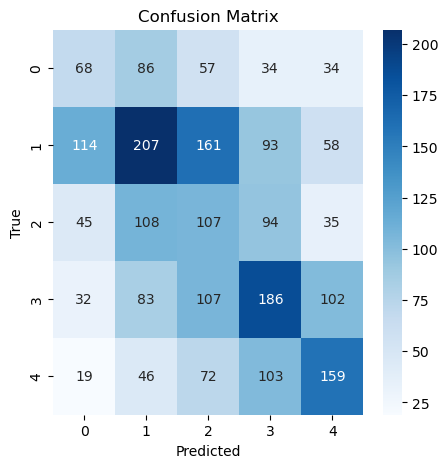

The Metrics of (LR Scratch):
Class-wise Metrics:
Class 0:
Precision: 0.24  Recall: 0.24  F1 Score: 0.24

Class 1:
Precision: 0.39  Recall: 0.33  F1 Score: 0.36

Class 2:
Precision: 0.21  Recall: 0.28  F1 Score: 0.24

Class 3:
Precision: 0.36  Recall: 0.36  F1 Score: 0.36

Class 4:
Precision: 0.41  Recall: 0.40  F1 Score: 0.40

Macro-Averaged Metrics:
Macro Precision: 0.32  Macro Recall: 0.32  Macro F1 Score: 0.32


In [32]:
# Metrics of LR from scratch

print('using from scratch functions') 

evaluate_model_scratch(test_labels, lr1_predictions, 5,"LR Scratch")

In [33]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def evaluate_model_sklearn(test_labels, predictions, num_classes,model_name):
    
    # Compute confusion matrix
    cm = confusion_matrix(test_labels, predictions)
    print(f'The confusion matrix ({model_name}):')    
    # Plot the confusion matrix
    plot_confusion_matrix(cm, num_classes)
    
    # Calculate per-class metrics
    precision_per_class = precision_score(test_labels, predictions, average=None, labels=range(num_classes))
    recall_per_class = recall_score(test_labels, predictions, average=None, labels=range(num_classes))
    f1_per_class = f1_score(test_labels, predictions, average=None, labels=range(num_classes))
    
    # Calculate different averages
    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')
    
    # Collect metrics in a dictionary to use with print_metrics function
    results = {
        "precision_per_class": precision_per_class,
        "recall_per_class": recall_per_class,
        "f1_per_class": f1_per_class,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1
    }
    
    # Print the metrics
    print(f'The Metrics of ({model_name}):')
    print_metrics(results)




using sklearn functions
The confusion matrix (LR SGD with Bigrams):


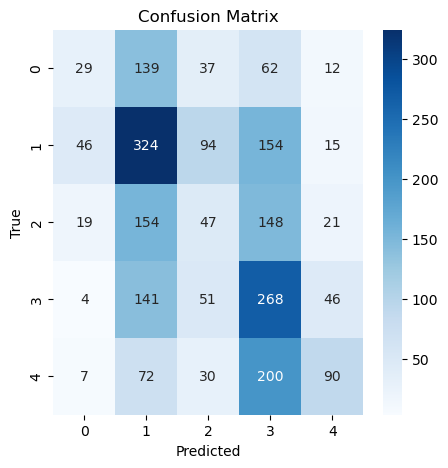

The Metrics of (LR SGD with Bigrams):
Class-wise Metrics:
Class 0:
Precision: 0.28  Recall: 0.10  F1 Score: 0.15

Class 1:
Precision: 0.39  Recall: 0.51  F1 Score: 0.44

Class 2:
Precision: 0.18  Recall: 0.12  F1 Score: 0.15

Class 3:
Precision: 0.32  Recall: 0.53  F1 Score: 0.40

Class 4:
Precision: 0.49  Recall: 0.23  F1 Score: 0.31

Macro-Averaged Metrics:
Macro Precision: 0.33  Macro Recall: 0.30  Macro F1 Score: 0.29


In [34]:
print('using sklearn functions') 
evaluate_model_sklearn(test_labels, sgd_predictions, 5,"LR SGD with Bigrams")

using from scratch functions
The confusion matrix (LR sklearn):


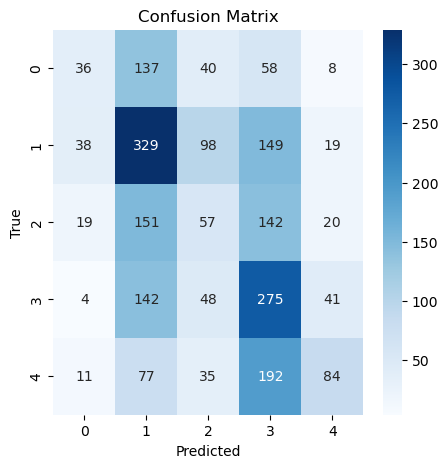

The Metrics of (LR sklearn):
Class-wise Metrics:
Class 0:
Precision: 0.33  Recall: 0.13  F1 Score: 0.19

Class 1:
Precision: 0.39  Recall: 0.52  F1 Score: 0.45

Class 2:
Precision: 0.21  Recall: 0.15  F1 Score: 0.17

Class 3:
Precision: 0.34  Recall: 0.54  F1 Score: 0.41

Class 4:
Precision: 0.49  Recall: 0.21  F1 Score: 0.29

Macro-Averaged Metrics:
Macro Precision: 0.35  Macro Recall: 0.31  Macro F1 Score: 0.30


In [46]:
print('using from scratch functions') 
evaluate_model_scratch(test_labels, lr_predictions, 5,"LR sklearn")

using sklearn functions
The confusion matrix (LR sklearn):


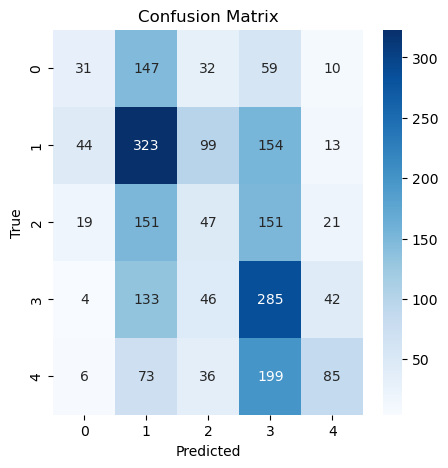

The Metrics of (LR sklearn):
Class-wise Metrics:
Class 0:
Precision: 0.30  Recall: 0.11  F1 Score: 0.16

Class 1:
Precision: 0.39  Recall: 0.51  F1 Score: 0.44

Class 2:
Precision: 0.18  Recall: 0.12  F1 Score: 0.14

Class 3:
Precision: 0.34  Recall: 0.56  F1 Score: 0.42

Class 4:
Precision: 0.50  Recall: 0.21  F1 Score: 0.30

Macro-Averaged Metrics:
Macro Precision: 0.34  Macro Recall: 0.30  Macro F1 Score: 0.29


In [35]:
print('using sklearn functions') 

evaluate_model_sklearn(test_labels, lr_predictions, 5,"LR sklearn")

In [38]:
import random

def show_random_predictions(test_sentences, test_labels, models):
    sample_indices = random.sample(range(len(test_sentences)), 5)  # Select 5 random samples
    
    table = PrettyTable()
    table.field_names = ["Test Sample", "True Label"] + list(models.keys())
    
    for idx in sample_indices:
        sample_text = test_sentences[idx]
        true_label = test_labels[idx]
        
        predictions = {model_name: model.predict([sample_text])[0] for model_name, model in models.items()}
        
        table.add_row([sample_text] + [true_label] + list(predictions.values()))
    
    print(table)

# Define models in a dictionary
models = {
    "LR From Scratch": lr1,
    "SGD with Bigrams": pipeline_sgd,
    "LR with Bigrams": pipeline_lr
}

# Show random predictions
show_random_predictions(test_sentences, test_labels, models)

+-------------------------------------------------------------------------------------------------------------------------------------+------------+-----------------+------------------+-----------------+
|                                                             Test Sample                                                             | True Label | LR From Scratch | SGD with Bigrams | LR with Bigrams |
+-------------------------------------------------------------------------------------------------------------------------------------+------------+-----------------+------------------+-----------------+
|                                           but like most rabbits it seems to lack substance                                          |     1      |        1        |        1         |        1        |
|                                                             no question                                                             |     2      |        2        |        1         